In [ ]:
!pip install langchain langgraph langchain-community langchain-groq langchain-huggingface chromadb sentence-transformers langchain-chroma beautifulsoup4

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import userdata
import os

GROQ_API_KEY = userdata.get('GROQ_API_KEY')
os.environ['GROQ_API_KEY'] = GROQ_API_KEY

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model_name="llama-3.3-70b-versatile",
    temperature=0.1,
    max_tokens=1024
)

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={'device': 'cuda'}
)

In [ ]:
medical_urls = [
    "https://www.mayoclinic.org/diseases-conditions/diabetes/symptoms-causes/syc-20371444",
    "https://www.webmd.com/diabetes/default.htm"
]

legal_urls = [
    "https://www.law.cornell.edu/wex/contract",
    "https://www.justia.com/contracts/"
]

technical_urls = [
    "https://docs.python.org/3/tutorial/index.html",
    "https://realpython.com/python-functions/"
]

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from typing import List


def load_web_data(urls: List[str], domain: str):
    """Load and process data from web URLs"""
    print(f"Loading {domain} data from web...")

    loader = WebBaseLoader(web_paths=urls)

    documents = loader.load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        length_function=len,
    )

    split_docs = text_splitter.split_documents(documents)

    for doc in split_docs:
        doc.metadata['domain'] = domain

    print(f"Loaded {len(split_docs)} chunks for {domain}")
    return split_docs

medical_docs = load_web_data(medical_urls, "medical")
legal_docs = load_web_data(legal_urls, "legal")
technical_docs = load_web_data(technical_urls, "technical")

Loading medical data from web...
✅ Loaded 43 chunks for medical
Loading legal data from web...
✅ Loaded 14 chunks for legal
Loading technical data from web...
✅ Loaded 13 chunks for technical


In [ ]:
from langchain_chroma import Chroma
from langchain_core.documents import Document

def create_vector_store_from_docs(docs: List[Document], collection_name: str):
    """Create vector store from loaded documents"""
    persist_dir = f"./chroma_db_{collection_name}"

    vectorstore = Chroma.from_documents(
        documents=docs,
        embedding=embeddings,
        collection_name=collection_name,
        persist_directory=persist_dir
    )

    return vectorstore


medical_vectorstore = create_vector_store_from_docs(medical_docs, "medical_web")
legal_vectorstore = create_vector_store_from_docs(legal_docs, "legal_web")
technical_vectorstore = create_vector_store_from_docs(technical_docs, "technical_web")

In [ ]:
medical_retriever = medical_vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 4}
)
legal_retriever = legal_vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 4}
)
technical_retriever = technical_vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 4}
)

In [ ]:
from langchain.tools.retriever import create_retriever_tool

medical_tool = create_retriever_tool(
    medical_retriever,
    "medical_search",
    "Search for medical information from Mayo Clinic and WebMD including diseases, treatments, and symptoms."
)

legal_tool = create_retriever_tool(
    legal_retriever,
    "legal_search",
    "Search for legal information from Cornell Law and Justia including contracts, laws, and legal procedures."
)

technical_tool = create_retriever_tool(
    technical_retriever,
    "technical_search",
    "Search for technical programming information from Python docs and Real Python including functions, tutorials, and coding concepts."
)

In [ ]:
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langgraph.graph import MessagesState

def medical_agent_node(state: MessagesState):
    messages = state["messages"]

    system_prompt = SystemMessage(content="""
    You are a medical information specialist. Use the medical_search tool to find relevant
    medical information from reputable sources. Provide helpful, accurate responses about
    health topics based on the retrieved information. Always mention that this is for
    informational purposes only and not medical advice.
    """)

    # Bind tools and get response
    llm_with_tools = llm.bind_tools([medical_tool])
    response = llm_with_tools.invoke([system_prompt] + messages)

    # If there are tool calls, execute them and get final response
    if hasattr(response, 'tool_calls') and response.tool_calls:
        # Execute each tool call
        for tool_call in response.tool_calls:
            try:
                # Execute the tool
                tool_result = medical_tool.invoke(tool_call["args"])

                # Create proper tool message
                tool_message = ToolMessage(
                    content=str(tool_result),
                    tool_call_id=tool_call["id"]
                )

                # Get final response with tool result
                final_response = llm.invoke([
                    system_prompt,
                    messages[-1],
                    response,
                    tool_message
                ])

                return {"messages": [final_response]}

            except Exception as e:
                error_response = AIMessage(content=f"I apologize, but I encountered an error while searching for medical information: {str(e)}")
                return {"messages": [error_response]}

    return {"messages": [response]}

In [ ]:
def legal_agent_node(state: MessagesState):
    messages = state["messages"]

    system_prompt = SystemMessage(content="""
    You are a legal information specialist. Use the legal_search tool to find relevant
    legal information from authoritative sources. Provide helpful responses about legal
    topics based on retrieved information. Always mention that this is general legal
    information and not legal advice.
    """)

    llm_with_tools = llm.bind_tools([legal_tool])
    response = llm_with_tools.invoke([system_prompt] + messages)

    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tool_call in response.tool_calls:
            try:
                tool_result = legal_tool.invoke(tool_call["args"])

                tool_message = ToolMessage(
                    content=str(tool_result),
                    tool_call_id=tool_call["id"]
                )

                final_response = llm.invoke([
                    system_prompt,
                    messages[-1],
                    response,
                    tool_message
                ])

                return {"messages": [final_response]}

            except Exception as e:
                error_response = AIMessage(content=f"I apologize, but I encountered an error while searching for legal information: {str(e)}")
                return {"messages": [error_response]}

    return {"messages": [response]}

In [ ]:
def technical_agent_node(state: MessagesState):
    messages = state["messages"]

    system_prompt = SystemMessage(content="""
    You are a technical programming specialist. Use the technical_search tool to find
    relevant programming information from official documentation and tutorials.
    Provide helpful coding guidance and explanations with examples when relevant.
    """)

    llm_with_tools = llm.bind_tools([technical_tool])
    response = llm_with_tools.invoke([system_prompt] + messages)

    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tool_call in response.tool_calls:
            try:
                tool_result = technical_tool.invoke(tool_call["args"])

                tool_message = ToolMessage(
                    content=str(tool_result),
                    tool_call_id=tool_call["id"]
                )

                final_response = llm.invoke([
                    system_prompt,
                    messages[-1],
                    response,
                    tool_message
                ])

                return {"messages": [final_response]}

            except Exception as e:
                error_response = AIMessage(content=f"I apologize, but I encountered an error while searching for technical information: {str(e)}")
                return {"messages": [error_response]}

    return {"messages": [response]}

In [ ]:
def route_to_agent(state: MessagesState) -> str:
    """Route to appropriate agent based on the last message content"""
    messages = state["messages"]
    last_message = messages[-1].content if messages else ""

    # Enhanced keyword-based routing logic
    medical_keywords = ["health", "disease", "treatment", "symptom", "medical", "doctor",
                       "diabetes", "medicine", "clinic", "patient", "diagnosis", "therapy",
                       "medication", "illness", "condition", "healthcare"]

    legal_keywords = ["law", "legal", "contract", "court", "agreement", "breach", "lawsuit",
                     "attorney", "judge", "legislation", "statute", "regulation", "compliance",
                     "liability", "jurisdiction", "precedent"]

    technical_keywords = ["code", "programming", "python", "function", "library", "git",
                         "software", "computer", "development", "algorithm", "debugging",
                         "syntax", "variable", "loop", "class", "module", "import"]

    last_message_lower = last_message.lower()

    # Count keyword matches
    medical_score = sum(1 for keyword in medical_keywords if keyword in last_message_lower)
    legal_score = sum(1 for keyword in legal_keywords if keyword in last_message_lower)
    technical_score = sum(1 for keyword in technical_keywords if keyword in last_message_lower)

    scores = {
        "medical_agent": medical_score,
        "legal_agent": legal_score,
        "technical_agent": technical_score
    }

    best_agent = max(scores, key=scores.get)

    if scores[best_agent] == 0:
        best_agent = "technical_agent"

    print(f"🎯 Routing to: {best_agent}")
    print(f"📊 Scores: {scores}")
    print(f"❓ Query: {last_message[:100]}...")

    return best_agent

In [ ]:
from langgraph.graph import StateGraph, MessagesState, START, END

workflow = StateGraph(MessagesState)

workflow.add_node("medical_agent", medical_agent_node)
workflow.add_node("legal_agent", legal_agent_node)
workflow.add_node("technical_agent", technical_agent_node)

workflow.add_conditional_edges(
    START,
    route_to_agent,
    {
        "medical_agent": "medical_agent",
        "legal_agent": "legal_agent",
        "technical_agent": "technical_agent"
    }
)

workflow.add_edge("medical_agent", END)
workflow.add_edge("legal_agent", END)
workflow.add_edge("technical_agent", END)

# Compile the graph
app = workflow.compile()

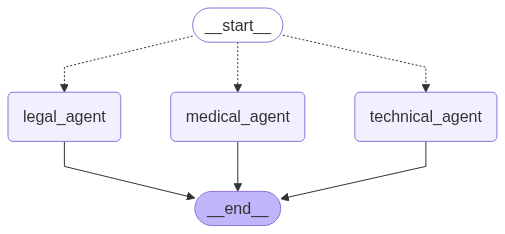

In [ ]:
app

In [ ]:
def query_web_rag_swarm(question: str):
    """Function to query the web-based RAG agent swarm"""
    initial_state = {
        "messages": [HumanMessage(content=question)]
    }

    print(f"\n🌐 Question: {question}")
    print("=" * 60)

    try:
        result = app.invoke(initial_state)

        final_message = result["messages"][-1]
        print(f"\n📝 Response: {final_message.content}")
        print("=" * 60)

        return result
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

In [ ]:
web_test_questions = [
    "What are the main symptoms and causes of diabetes?",
    "What are the essential elements needed for a valid contract?",
    "How do I create and use functions in Python?",
    "What are the treatment options for type 2 diabetes?",
    "What constitutes a breach of contract?",
    "What are Python modules and how do I import them?"
]

print("🧪 Testing the RAG Agent Swarm...")
print("=" * 60)

# Test each question with web-loaded data
for question in web_test_questions:
    query_web_rag_swarm(question)

🧪 Testing the RAG Agent Swarm...

🌐 Question: What are the main symptoms and causes of diabetes?
🎯 Routing to: medical_agent
📊 Scores: {'medical_agent': 2, 'legal_agent': 0, 'technical_agent': 0}
❓ Query: What are the main symptoms and causes of diabetes?...

📝 Response: The main symptoms of diabetes include increased thirst, frequent urination, weight loss, presence of ketones in the urine, fatigue, irritability, blurry vision, slow-healing sores, and frequent infections. The causes of diabetes vary depending on the type. Type 1 diabetes is an autoimmune disease in which the body's immune system attacks and destroys the insulin-producing beta cells in the pancreas. Type 2 diabetes is caused by a combination of genetic and lifestyle factors, including insulin resistance and impaired insulin secretion. Gestational diabetes is caused by hormonal changes and insulin resistance during pregnancy.

This information is for informational purposes only and not medical advice. If you have concer